In [153]:
import os
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import positional_encodings
from datasets.cityscapes import cityscapesDataset
from datasets.pascalvoc import pascalVOCDataset
import matplotlib.pyplot as plt

In [3]:
local_path = "./VOCdevkit/VOC2012"
pckgs_names = ["gtFine_trainvaltest.zip","leftImg8bit_trainvaltest.zip"]
dir_names = ["gtFine", "leftImg8bit"]

In [5]:
training_data = pascalVOCDataset(local_path, split="train")
len(training_data)

1464

In [17]:
model = r2unet.R2UNet()

In [31]:
sample = training_data[5][0]

In [32]:
passed = model(sample.unsqueeze(dim=0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


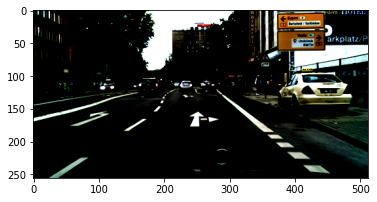

In [33]:
plt.imshow(training_data[5][0].permute(1,2,0))

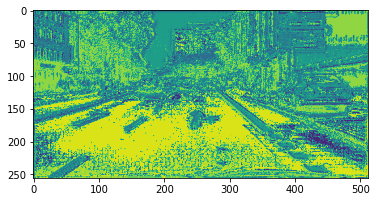

In [34]:
passed = passed.detach().cpu()
plt.imshow(torch.argmax(passed.squeeze(dim=0),dim = 0))

In [6]:
img, lbl = training_data[0]

In [7]:
img.size()

torch.Size([3, 512, 512])

In [267]:
import warnings

class Conv1dPosEncRelu(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                    padding=0, bias=True, positional_encoding=True):
        super(Conv1dPosEncRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.positional_encoding = positional_encoding
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                                stride=stride, padding=padding, bias=bias)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        Q = self.conv(inputs)
        if self.positional_encoding:
            encoder = pe.PositionalEncodingPermute1D(self.out_channels)
            PE = encoder(torch.zeros(Q.size()))
            Q = Q + PE
        outputs = self.relu(Q)
        return outputs 

class Conv1dPosEncSigmoid(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                    padding=0, bias=True, positional_encoding=True):
        super(Conv1dPosEncSigmoid, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.positional_encoding = positional_encoding
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                                stride=stride, padding=padding, bias=bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        Q = self.conv(inputs)
        if self.positional_encoding:
            encoder = pe.PositionalEncodingPermute1D(self.out_channels)
            PE = encoder(torch.zeros(Q.size()))
            Q = Q + PE
        outputs = self.sigmoid(Q)
        return outputs 

class HANet(nn.Module):
    """ Height-driven Attention Networks (HaNet) class """

    def __init__(self, l_dims, h_dims, ww_pool="average", attention_height=16, 
                    reduction_ratio=32,n_convolutions=3, positional_encoding=True):
        """ Initialize an instance of HANet. 

            Parameters:
                l_dims ([int, int, int]): lower-level dimensions
                h_dims ([int, int, int]): higher-level dimensions
                ww_pool ({"average", "max"}): width-wise pooling type
                attention_height (int): height of the attention's map
                reduction_ratio (int): reduction ratio
                n_convolutions (int): number of convolutions to create the attention 
                map
                position_encoding (bool): determines if positional encoding is
                injected after each convolution.

            Return:
                (torch.Tensor): height-driven attention map
        """
        assert len(l_dims) == 3, "all input dimensions CxHxW have to be provided"
        assert len(h_dims) == 3, "all output dimensions CxHxW have to be provided"
        assert ww_pool in ["average", "max"], "width-wise pooling can only be 'average' or 'max'"
        assert n_convolutions >= 1, "at least one convolution is needed"

        super(HANet, self).__init__()
        self.C_l, self.H_l, self.W_l = l_dims
        self.C_h, self.H_h, self.W_h = h_dims
        self.a_height = attention_height     
        self.reduction_ratio = reduction_ratio  
        self.n_convolutions = n_convolutions
        # G_pool
        if ww_pool == "average":
            self.ww_pooling = nn.AvgPool2d(kernel_size=(1, self.W_l), stride=(1,1))
        else:
            self.ww_pooling = nn.MaxPool2d(kernel_size=(1, self.W_l), stride=(1,1))
        # G_down
        self.down = nn.Upsample(size=(self.a_height, 1), mode="bilinear",
                                    align_corners=False)
        # G_conv1, G_conv2, ..., G_convN
        self.convs = self._add_convolutions()
        # G_up
        self.up = nn.Upsample(size=(self.H_h, 1), mode="bilinear", align_corners=False)

    def forward(self, X_l): 
        """ Compute attention map 

            Parameters:
                X_l (torch.Tensor): low-level input
            
            Returns:
                (torch.Tensor): attention map
        """
        print("X_l = ", X_l.size()[1:])
        Z = self.ww_pooling(X_l)
        print("Z = ", Z.size()[1:])
        Z_hat = self.down(Z)
        Z_hat = Z_hat.squeeze(-1)
        print("Z_hat = ", Z_hat.size()[1:])
        Q = self.convs[0](Z_hat)
        print(" Q_1 = ", Q.size()[1:])
        for i in range(1, self.n_convolutions):
            Q = self.convs[i](Q)
            print(" Q_{} = ".format(i+1), Q.size()[1:])
        A_hat = Q.unsqueeze(-1)
        print("A_hat = ", A_hat.size()[1:])
        A = self.up(A_hat)
        print("A = ", A.size()[1:])
        return A

    def _add_convolutions(self):
        layers = []
        in_channels = self.C_l
        if (self.C_l // self.reduction_ratio) == 0 and self.n_convolutions > 1:
            warnings.warn("lower-level channels too small for the given reduction_ratio - n_convolutions set to 1")
            self.n_convolutions = 1
        for i in range(1, self.n_convolutions):
            out_channels = i * (self.C_l // self.reduction_ratio) # i * (C_l / r)
            layers.append(Conv1dPosEncRelu(in_channels, out_channels))
            in_channels = out_channels
        layers.append(Conv1dPosEncSigmoid(in_channels, self.C_h))
        return nn.Sequential(*layers)
        
        

In [269]:
model = HANet((64, 512, 512), (128, 512, 512))

model

HANet(
  (ww_pooling): AvgPool2d(kernel_size=(1, 512), stride=(1, 1), padding=0)
  (down): Upsample(size=(16, 1), mode=bilinear)
  (convs): Sequential(
    (0): Conv1dPosEncRelu(
      (conv): Conv1d(64, 2, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): Conv1dPosEncRelu(
      (conv): Conv1d(2, 4, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (2): Conv1dPosEncSigmoid(
      (conv): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (sigmoid): Sigmoid()
    )
  )
  (up): Upsample(size=(512, 1), mode=bilinear)
)

In [261]:
outputs = model.forward(torch.rand(1,16,512,512))

X_l =  torch.Size([16, 512, 512])
Z =  torch.Size([16, 512, 1])
Z_hat =  torch.Size([16, 16])
 Q_1 =  torch.Size([128, 16])
A_hat =  torch.Size([128, 16, 1])
A =  torch.Size([128, 512, 1])


In [119]:
my_tensor = torch.Tensor([[
    [6,5, 12],
    [1,2, -2],
    [3,4, 5]], 
    [
    [1,2,4],
    [4,5,2], 
    [9,44,43]]])
my_tensor.size()

torch.Size([2, 3, 3])

In [120]:
my_tensor

tensor([[[ 6.,  5., 12.],
         [ 1.,  2., -2.],
         [ 3.,  4.,  5.]],

        [[ 1.,  2.,  4.],
         [ 4.,  5.,  2.],
         [ 9., 44., 43.]]])

In [121]:
my_tensor

tensor([[[ 6.,  5., 12.],
         [ 1.,  2., -2.],
         [ 3.,  4.,  5.]],

        [[ 1.,  2.,  4.],
         [ 4.,  5.,  2.],
         [ 9., 44., 43.]]])

In [122]:
my_tensor.size()

torch.Size([2, 3, 3])

In [123]:
model = HANet(in_dims=(2,2,3), out_dims=(3,3,1))

In [124]:
my_tensor = model.forward(my_tensor.unsqueeze(0))
my_tensor

/home/pabvald/Documents/DSAI/simple-imageseg/.env/lib/python3.7/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


tensor([[[[ 5.8333],
          [ 3.0833]],

         [[ 2.6667],
          [24.9167]]]])

In [228]:
my_tensor = torch.ones(1,3,2,1)

In [229]:
my_tensor.size()

torch.Size([1, 3, 2, 1])

In [230]:
my_tensor

tensor([[[[1.],
          [1.]],

         [[1.],
          [1.]],

         [[1.],
          [1.]]]])

In [231]:
my_tensor = F.interpolate(my_tensor, size=(8,1), mode="bilinear")

/home/pabvald/Documents/DSAI/simple-imageseg/.env/lib/python3.7/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [232]:
my_tensor.size()

torch.Size([1, 3, 8, 1])

In [233]:
my_tensor

tensor([[[[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]]]])